# Inference with past observations

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from inference_model import MeanField, DynamicMessagePassing
from sir_model import ProximityModel, NetworkModel
import networkx as nx
from networkx.generators.random_graphs import connected_watts_strogatz_graph, erdos_renyi_graph

## Here is the list of parameters

In [2]:
N = 4000 #number of individuals
N_patient_zero = 20 #number of patients 0
scale = 1.0 #scale of the graphs
mu = 0.01 # mu -> recover
lamb = 0.02 # lamb -> transmission
proba_contact = 0.1 # proba that an edge is activated as a contact 

# seed for reproducibility
seed = 878

# Testing paramters
t_test = 100 # T_TEST IS HERE
n_test = 100 
tau = 5

init_all_susc = 1 # if one, inference starts with all susceptible, otherwise, it starts with the prior
using_bp = 0 # if one, use bp, overwise use mean fieldish equations

In [3]:
if (using_bp ==0):
    MyInferenceModel = MeanField
else:
    MyInferenceModel = DynamicMessagePassing

# creating list of patients 0
List_patient_zero = np.random.randint(N, size=N_patient_zero)
initial_states = np.zeros(N)
initial_states[List_patient_zero] = 1

np.random.seed(seed)
# generate graph
#graph = erdos_renyi_graph(n=N, p=0.01, seed=seed)
graph = connected_watts_strogatz_graph(n=N, k=30, p=0.01, seed=seed)
layout = nx.random_layout(graph)
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 4000
Number of edges: 60000
Average degree:  30.0000


In [4]:
model =  NetworkModel(
    graph=graph, mu=0.01, lamb=0.02, 
    proba_contact=proba_contact, layout=layout,
    initial_states = initial_states
)
print("expected number of contacts %.1f (per time step)" % model.n_contacts)
model.run(300, print_every=50)

expected number of contacts 3.0 (per time step)
Generating transmissions
Running simulation
t = 0 / 300
t = 50 / 300
t = 100 / 300
t = 150 / 300
t = 200 / 300
t = 250 / 300


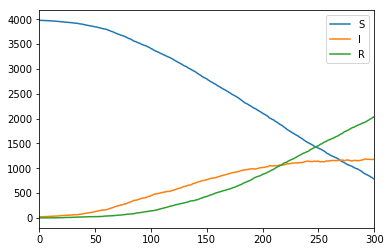

In [5]:
counts = model.get_counts()
counts.plot();

## (Past) Observations

Let's say we have done a series of random tests in the past, which gives us our past observations.

In [6]:
def generate_observations(model, tests):
    observations = []
    for t_test, n_test in tests.items():
        tested = np.random.choice(model.N, n_test, replace=False)
        for i in tested:
            obs = dict(i=i, t_test=t_test, s=model.states[t_test,i])
            observations.append(obs)
    return observations

In [7]:
tests = {t: t//2 for t in range(t_test)}
past_observations = generate_observations(model, tests)
print("number of past observations", len(past_observations))

number of past observations 2450


## Scenario 

Let's say at time `t_test` we have `n_test` of individuals returned positive to the virus. We have a limited budget of `n_new_test` to perform and we want to efficently target the tests.

We compare two testing strategies

1. naive contact tracing : say we list all the person that have been in contact with the known infected inviduals
2. use inference to estimate the probalities and provide a list of the most probably infected persons

Remarks
- we don't know when they got infected. Maybe in another scenario we can have an informed estimate of that time (eg based on symptoms or other features). Here will do a coarse approximation and say they were all infected at time t_test - tau, where tau is chosen.
- for strategy 1, I don't know the rule for contact tracing. Here we simply list all past contacts of the tested people, say during t_test - tau and t_test, and count the number of encounters.

In [8]:
# get last infected and tested people
last_infected, = np.where(model.states[t_test,:] == 1)
last_tested = list(last_infected[:n_test])
n_last_infected = len(last_infected)
n_last_tested = len(last_tested)
print(f"n_last_infected = {n_last_infected} n_last_tested = {n_last_tested}")
# get past tested people (observed infected in past_observations)
past_tested = [obs["i"] for obs in past_observations if obs["s"]==1]
full_tested = last_tested + past_tested
n_full_tested = len(full_tested)
print(f"n_full_tested = {n_full_tested}")
# targets : last infected people, but not tested yet
target = [i for i in last_infected if i not in full_tested]
n_target = len(target)
print(f"remaining infected people to detect n_target={n_target}")
if (n_target==0):
    raise ValueError("Choose other parameters or rerun, no target left to detect")

n_last_infected = 452 n_last_tested = 100
n_full_tested = 266
remaining infected people to detect n_target=260


In [9]:
# pool to target : everyone except already tested
actual_status = pd.DataFrame(
    dict(i=i, s=s, infected=1*(s==1)) 
    for i, s in enumerate(model.states[t_test])
    if i not in full_tested
)
actual_status.groupby('s').size()

s
0.0    3408
1.0     260
2.0     117
dtype: int64

## Strategy 1 (naive contact tracing)

In [10]:
def csr_to_list(x):
    x_coo = x.tocoo()
    return zip(x_coo.row, x_coo.col, x_coo.data)

# get past contacts of last_tested people
contacts = pd.DataFrame(
    dict(i=i, j=j, t=t) 
    for t in range(t_test - tau, t_test)
    for i, j, _ in csr_to_list(model.transmissions[t])
    if j in last_tested and i not in full_tested
)
encounters = contacts.groupby("i").size().rename("count").reset_index()
encounters = pd.merge(encounters, actual_status, on="i", how="inner")
encounters = encounters.sort_values(by="count", ascending=False)
encounters["rank"] = range(encounters.shape[0])
encounters["total_infected"] = encounters["infected"].cumsum()
encounters.head()

,i,count,infected,s,rank,total_infected
256,1680,14,0,0.0,0,0
196,1337,13,0,2.0,1,0
135,1211,12,0,0.0,2,0
194,1335,11,0,0.0,3,0
198,1348,11,0,0.0,4,0


## Strategy 2 (inference)

Let's say we start the inference at t_start, and use the actual frequencies 
as the initial proba.

In [11]:
def generate_initial_probas(states):
    "generate initial proba according to the freq of states"
    freqs = [np.mean(states==s) for s in [0,1,2]]
    print("freqs = ", freqs)
    N = len(states)
    initial_probas = np.broadcast_to(freqs, (N, 3)).copy()
    return initial_probas

#The value of t_start below decides when we initialize the probas
t_start=0
if (init_all_susc == 1):
    initial_probas = generate_initial_probas(states=np.zeros(N))    #INIT ALL SUSCEPTIBLE
else:
    initial_probas = generate_initial_probas(states=model.states[t_start]) #INIT FROM MODEL

infer = MyInferenceModel(initial_probas, model.x_pos, model.y_pos)

freqs =  [1.0, 0.0, 0.0]


The observations are the n_test tests at time t_test + past observations.

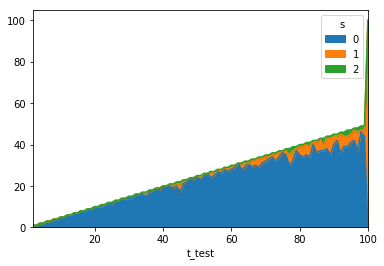

In [12]:
last_observations = [dict(i=i, t_test=t_test, s=1) for i in last_tested]
observations = past_observations + last_observations
for obs in observations:
    obs["s"] = int(obs["s"])
    obs["tau"] = tau
df_full_obs = pd.DataFrame(observations)
df_full_obs.groupby(["t_test", "s"]).size().unstack("s").plot.area(stacked=True);

**Warning** One must be careful to shift the transmissions and the observations by t_start

In [13]:
transmissions = model.transmissions[t_start:]
for obs in observations:
    obs["t"] = obs["t_test"]-t_start
    obs["t_I"] = obs["t"] - obs["tau"]
infer.time_evolution(model.recover_probas, transmissions, observations, print_every=50)

t = 0 / 300
t = 50 / 300
t = 100 / 300
t = 150 / 300
t = 200 / 300
t = 250 / 300


In [14]:
# most probably infected
probas_I = pd.DataFrame(
    dict(i=i, p=p) 
    for i, p in enumerate(infer.probas[t_test-t_start,:,1])
    if i not in full_tested
)
probas_I = pd.merge(probas_I, actual_status, on="i", how="inner")
probas_I = probas_I.sort_values(by="p", ascending=False)
probas_I["rank"] = range(probas_I.shape[0])
probas_I["total_infected"] = probas_I["infected"].cumsum()
probas_I.head()

,i,p,infected,s,rank,total_infected
2892,3051,0.593109,1,1.0,0,1
2893,3054,0.581840,1,1.0,1,2
2894,3055,0.578696,1,1.0,2,3
2896,3060,0.575809,1,1.0,3,4
2719,2861,0.564665,0,2.0,4,4


## Comparison

In [15]:
def get_random_guess():
    random_ranking = [i for i in np.random.permutation(model.N) if i not in full_tested]
    df = pd.DataFrame({"i": random_ranking})
    df["rank"] = range(df.shape[0])
    df = pd.merge(df, actual_status, on="i", how="inner")
    df = df.sort_values(by="rank")
    df["total_infected"] = df["infected"].cumsum()
    return df

random_guess = get_random_guess()

n_target = 260


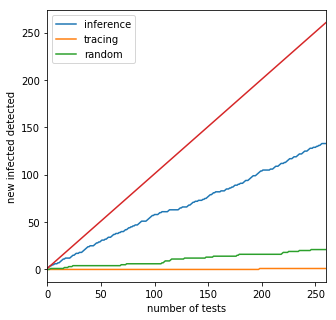

In [16]:
print(f"n_target = {n_target}")

fig, ax = plt.subplots(1,1,figsize=(5,5))
probas_I.plot(ax=ax, x="rank", y="total_infected", label="inference")
encounters.plot(ax=ax, x="rank", y="total_infected", label="tracing")
random_guess.plot(ax=ax, x="rank", y="total_infected", label="random")
ax.set(ylabel="new infected detected", xlabel="number of tests")
ax.plot([0,n_target], [1,n_target+1])
ax.set_xlim(0, n_target);
#plt.savefig("comparison_npo360_dtinit60")

## Counts estimated vs actual

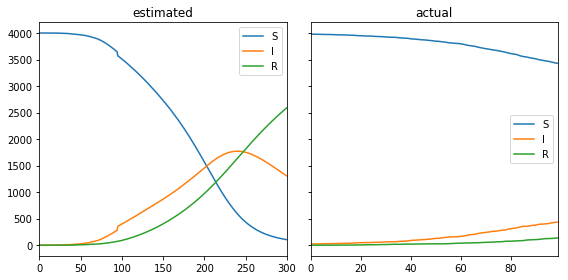

In [17]:
fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
counts_est = infer.get_counts()
counts_est.index += t_start
counts_est.plot(ax=axs[0])
axs[0].set_title("estimated")
counts[t_start:t_test].plot(ax=axs[1])
axs[1].set_title("actual")
fig.tight_layout()

In [18]:
assert np.allclose(infer.probas.sum(axis=2),1)
assert infer.probas.min()>=0
assert infer.probas.max()<=1

## Tables

In [19]:
n_untested = model.N - n_full_tested
print(f"n_full_tested = {n_full_tested}, n_last_infected={n_last_infected}, n_untested={n_untested}")

n_full_tested = 266, n_last_infected=452, n_untested=3734


In [20]:
def time_evo_proba(i):
    evo = pd.DataFrame(infer.probas[:,i,:], columns=["S","I","R"])
    evo.index.name="t"
    evo.plot(title=f"i={i}");

In [21]:
merged = pd.merge(encounters, probas_I, on=["i","infected","s"], how="inner",suffixes=["_1","_2"])
merged.sort_values(by="rank_1").head(20)

,i,count,infected,s,rank_1,total_infected_1,p,rank_2,total_infected_2
0,1680,14,0,0.0,0,0,0.406838,111,61
1,1337,13,0,2.0,1,0,0.332066,205,105
2,1211,12,0,0.0,2,0,0.086456,728,231
3,1335,11,0,0.0,3,0,0.311167,228,117
4,1348,11,0,0.0,4,0,0.263618,289,139
5,1357,10,0,0.0,5,0,0.252120,305,147
6,1350,10,0,2.0,6,0,0.214759,383,165
7,1223,9,0,2.0,7,0,0.383236,142,73
8,1201,9,0,0.0,8,0,0.329829,207,105
9,1338,9,0,0.0,9,0,0.232274,345,157


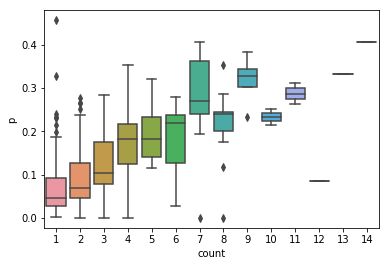

In [22]:
import seaborn as sns
sns.boxplot(x="count", y="p", data=merged);